<a href="https://colab.research.google.com/github/ropholuo/ESE546-Intro-to-Deep-learning/blob/main/jinhuil_hw4_problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**(b)**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

    def forward(self, x):
        return self.m(x)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss, avg_loss = [], []

    model.train()

    for epoch in range(epochs):
      for i, (images, labels) in enumerate(train_loader):
          # Move tensors to configured device
          images = images.to(device)
          labels = labels.to(device)
          #Forward Pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss.append(loss.item())

          if (i+epoch*391+1)%100 == 0:
            scheduler.step()
            avg_loss.append(np.mean(train_loss))
            train_loss = []

    return avg_loss

In [ ]:
model = allcnn_t().to(device)
epochs = 35
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=10**(-5), momentum=0.9, weight_decay=10**(-3))
# TODO: Set milestones for stepping learning rate
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=list(range(1,int(31*391/100))), gamma=1.1)
# Training loop called here
avg_loss = train(model, optimizer, criterion, trainloader, testloader, epochs)

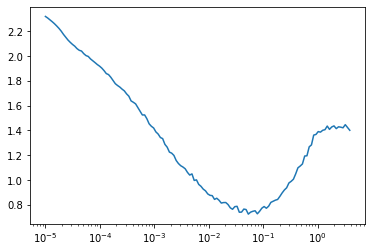

In [ ]:
lr_update = np.logspace(0,len(avg_loss)-1,num=len(avg_loss),base=1.1)*10**(-5)
plt.semilogx(lr_update,avg_loss)

Find the maximum learning rate by locating the minimum of this plot

In [ ]:
index = np.argmin(avg_loss)
lr_update[index]

0.05313022611848313

**(c)**

$\eta_{max}$ is set to be 0.053/10 = 0.0053

In [ ]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss, val_loss = [], []
    T = epochs*391
    T0 = T/5
    lr_max = 0.0053
    lr_list = []
    loss_list = []

    for epoch in range(epochs):
      model.train()
      for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        t = epoch*391+i
        if t <= T0:
          for g in optimizer.param_groups:
            g['lr'] = 10**(-4) + t/T0*lr_max
            lr_list.append(g['lr'])
        else:
          for g in optimizer.param_groups:
            g['lr'] = lr_max * np.cos(np.pi/2*(t-T0)/(T-T0)) + 10**(-6)
            lr_list.append(g['lr'])
        loss_list.append(loss.item())

        optimizer.step()
        if (epoch*391+i)%100 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
          train_loss.append(np.mean(loss_list))
          loss_list = []

          model.eval()
          with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

          print('Validation loss of the network on the test images: {} %'.format(100 * correct / total))
          val_loss.append(100 * correct / total)
          model.train()

    return train_loss, val_loss, lr_list

In [ ]:
model = allcnn_t().to(device)
epochs = 100
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=10**(-5), momentum=0.9, weight_decay=10**(-3))
# Training loop called here
train_loss, val_loss, lr_list = train(model, optimizer, criterion, trainloader, testloader, epochs)

Epoch [1/100], Step [1/391], Loss: 2.2988
Validation loss of the network on the test images: 10.0 %
Epoch [1/100], Step [101/391], Loss: 2.2031
Validation loss of the network on the test images: 14.77 %
Epoch [1/100], Step [201/391], Loss: 2.0405
Validation loss of the network on the test images: 17.42 %
Epoch [1/100], Step [301/391], Loss: 1.9759
Validation loss of the network on the test images: 18.14 %
Epoch [2/100], Step [10/391], Loss: 1.9684
Validation loss of the network on the test images: 19.77 %
Epoch [2/100], Step [110/391], Loss: 1.8300
Validation loss of the network on the test images: 21.34 %
Epoch [2/100], Step [210/391], Loss: 1.7351
Validation loss of the network on the test images: 21.62 %
Epoch [2/100], Step [310/391], Loss: 1.8300
Validation loss of the network on the test images: 22.55 %
Epoch [3/100], Step [19/391], Loss: 1.7339
Validation loss of the network on the test images: 26.0 %
Epoch [3/100], Step [119/391], Loss: 1.7307
Validation loss of the network on t

Because run the entire validation set in every weight update can be extremely expensive, so I validate it every 100 weight updates.
Also, for the sake of plot smoothness, I calculate the average validation accuracy per 100 weight updates.

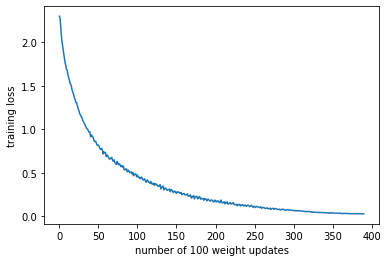

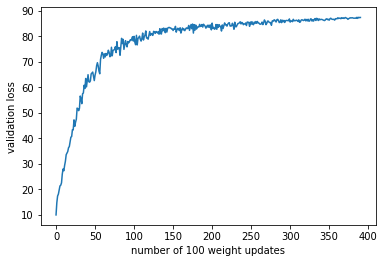

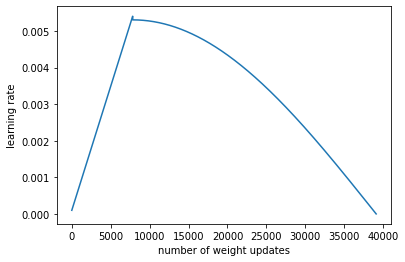

In [ ]:
plt.figure()
plt.plot(train_loss); plt.ylabel('training loss'); plt.xlabel('number of 100 weight updates')
plt.figure()
plt.plot(val_loss); plt.ylabel('validation loss'); plt.xlabel('number of 100 weight updates')
plt.figure()
plt.plot(lr_list); plt.ylabel('learning rate'); plt.xlabel('number of weight updates')
plt.show()

**(d)**

In [ ]:
def train(net, criterion, train_loader, test_loader, epochs, lr_max, momentum):
    model = net.to(device)
    T = epochs*391
    T0 = T/5
    optimizer = optim.SGD(model.parameters(), lr=10**(-5), momentum=momentum, weight_decay=10**(-3))

    for epoch in range(epochs):
      model.train()
      for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        t = epoch*391+i
        if t <= T0:
          for g in optimizer.param_groups:
            g['lr'] = 10**(-4) + t/T0*lr_max
        else:
          for g in optimizer.param_groups:
            g['lr'] = lr_max * np.cos(np.pi/2*(t-T0)/(T-T0)) + 10**(-6)

        optimizer.step()

    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for i, (images, labels) in enumerate(test_loader):
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print('Validation error of the network on the test images: {} %'.format((1-correct / total)*100))

    return 

In [ ]:
epochs = 50
lr_max = 0.0053
criterion = nn.CrossEntropyLoss()

model with $\eta_{max}$ and $\rho = 0.9$

In [ ]:
model = allcnn_t().to(device)
train(model, criterion, trainloader, testloader, epochs, lr_max, momentum=0.9)

Validation error of the network on the test images: 13.739999999999997 %


model with $5\eta_{max}$ and $\rho = 0.5$

In [ ]:
model = allcnn_t().to(device)
train(model, criterion, trainloader, testloader, epochs, lr_max*5, momentum=0.5)

Validation error of the network on the test images: 14.380000000000004 %


model with $\eta_{max}$ and $\rho = 0.5$

In [ ]:
model = allcnn_t().to(device)
train(model, criterion, trainloader, testloader, epochs, lr_max, momentum=0.5)

Validation error of the network on the test images: 23.350000000000005 %
